# Predicting Financial News Sentiment

## Read in Data

In [2]:
import pandas as pd
import numpy as np

import tensorflow as tf
from tensorflow.keras import backend as K

from scipy.sparse import csr_matrix, vstack, hstack
from sklearn.metrics import roc_auc_score

In [6]:
train = pd.read_csv("data/train.csv").dropna()
test = pd.read_csv("data/test.csv").dropna()
token_train = train['Text_unigram']
token_test = test['Text_unigram']
y_train = np.array(train['Sentiment'])
y_test = np.array(test['Sentiment'])
X_train = train.drop(['Sentiment', 'Text_unigram'], axis=1)
feature_names = X_train.columns
X_train = X_train.values
X_test = test.drop(['Sentiment', 'Text_unigram'], axis=1).values
gen_features = ['word_count', 'unigram_count', 'unique_word_count', 'unique_unigram_count', 'stopword_count', 'mean_word_length', 'mean_unigram_length', 'char_count', 'punctuation_count', 'number_count']

Response variable for sentiment is -1 or 1. Therefore, we have custom loss and accuracy functions to adapt these values to work with the models

In [9]:
def custom_accuracy(y_true, y_pred):
    # Since y_pred comes from tanh, values will be between -1 and 1.
    # We convert these to 1 and -1 for comparison.
    y_pred_labels = K.cast(K.greater(y_pred, 0), K.floatx()) * 2 - 1
    # Compare predicted labels to true labels
    correct_predictions = K.equal(y_true, y_pred_labels)
    # Calculate accuracy
    return K.mean(correct_predictions, axis=-1)

def custom_binary_crossentropy(y_true, y_pred):
    # Transform y_true to 0 and 1.
    y_true_transformed = K.cast((y_true + 1) / 2, dtype='float64')
    y_pred_transformed = K.cast((y_pred + 1) / 2, dtype='float64')

    # Compute binary crossentropy
    bce = K.binary_crossentropy(y_true_transformed, y_pred_transformed, from_logits=False)
    
    return K.mean(bce)

## Feed Forward Implementation

Load the model using the following chunk, rather than retraining it.

In [40]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.regularizers import l2
from tensorflow.keras.optimizers.legacy import Adam

model = Sequential()
model.add(Dense(16, activation='relu', input_dim=X_train.shape[1], kernel_regularizer=l2(0.0001))) #best 0.0001
model.add(Dense(24, activation='relu', kernel_regularizer=l2(0.0001)))
model.add(Dense(16, activation='relu', kernel_regularizer=l2(0.008176190368614009))) #layers 16, 24, 16 based on keras tuner
model.add(Dense(1, activation='tanh'))  # Output layer


adam = Adam(learning_rate=0.0002)

model.compile(optimizer=adam, loss=custom_binary_crossentropy, metrics=[custom_accuracy])
# Fit the model - assuming your data is ready and appropriately preprocessed
history = model.fit(X_train, y_train, epochs=1000, batch_size=8, validation_split=0.1)

Epoch 1/1000
663/663 [==============================] - 1s 745us/step - loss: 0.8919 - custom_accuracy: 0.5707 - val_loss: 0.8204 - val_custom_accuracy: 0.3203
Epoch 2/1000
663/663 [==============================] - 0s 622us/step - loss: 0.7346 - custom_accuracy: 0.5988 - val_loss: 1.0128 - val_custom_accuracy: 0.1068
Epoch 3/1000
663/663 [==============================] - 0s 604us/step - loss: 0.7105 - custom_accuracy: 0.6092 - val_loss: 0.7262 - val_custom_accuracy: 0.4237
Epoch 4/1000
663/663 [==============================] - 0s 609us/step - loss: 0.6932 - custom_accuracy: 0.6175 - val_loss: 0.7796 - val_custom_accuracy: 0.3237
Epoch 5/1000
663/663 [==============================] - 0s 599us/step - loss: 0.6741 - custom_accuracy: 0.6339 - val_loss: 0.8494 - val_custom_accuracy: 0.2983
Epoch 6/1000
663/663 [==============================] - 0s 654us/step - loss: 0.6468 - custom_accuracy: 0.6695 - val_loss: 0.6538 - val_custom_accuracy: 0.6186
Epoch 7/1000
663/663 [==================

In [10]:
from tensorflow.keras.models import load_model
#model.save('data/ffmodel') #save model
ffmodel = load_model('data/ffmodel', custom_objects={'custom_accuracy': custom_accuracy, 'custom_binary_crossentropy': custom_binary_crossentropy})
#history_df = pd.DataFrame(history.history)
#history_csv_file_path = 'data/ffmodel_training_history.csv'
#history_df.to_csv(history_csv_file_path, index=False)
ff_history_df = pd.read_csv('data/ffmodel_training_history.csv')

Hyperparameter Tuning

In [ ]:
import keras_tuner as kt

def build_model(hp):
    model = Sequential()
    model.add(Dense(units=hp.Int('layer1', min_value=8, max_value=64, step=8),
                    activation='relu', input_dim=X_train.shape[1],
                    kernel_regularizer=l2(hp.Float('l2_1', min_value=1e-5, max_value=1e-2, sampling='LOG'))))
    #model.add(Dropout(hp.Float('dropout', min_value=0.0, max_value=0.5, step=0.1)))
    model.add(Dense(units=hp.Int('layer2', min_value=8, max_value=32, step=8),
                    activation='relu',
                    kernel_regularizer=l2(hp.Float('l2_2', min_value=1e-5, max_value=1e-2, sampling='LOG'))))
    model.add(Dense(units=hp.Int('layer3', min_value=8, max_value=16, step=8),
                    activation='relu',
                    kernel_regularizer=l2(hp.Float('l2_3', min_value=1e-5, max_value=1e-2, sampling='LOG'))))
    # You can also add Dropout here if needed
    model.add(Dense(1, activation='tanh'))

    adam = Adam(learning_rate=hp.Float('learning_rate', min_value=0.00005, max_value=0.0002, step =0.00005))
    model.compile(optimizer=adam, loss=custom_binary_crossentropy, metrics=[custom_accuracy])

    return model

# Create a tuner
tuner = kt.Hyperband(
    build_model,
    objective=kt.Objective("val_custom_accuracy", direction="max"),
    max_epochs=50,
    hyperband_iterations=2)

# Perform hyperparameter tuning
tuner.search(X_train, y_train, 
             epochs=50, validation_split=0.1, 
             callbacks=[tf.keras.callbacks.EarlyStopping(patience=5)])

# Get the optimal hyperparameters
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]


In [ ]:

# You can now access the best hyperparameters as follows:
best_layer1 = best_hps.get('layer1')
best_layer2 = best_hps.get('layer2')
best_layer3 = best_hps.get('layer3')
best_l2_1 = best_hps.get('l2_1')
best_l2_2 = best_hps.get('l2_2')
best_l2_3 = best_hps.get('l2_3')
best_learning_rate = best_hps.get('learning_rate')
print(best_hps.values)
# Now you can use these best hyperparameters to build the best model
best_model = tuner.hypermodel.build(best_hps)

# Summary of the best model
best_model.summary()

# You can now train the best model with the optimal hyperparameters
history = best_model.fit(X_train, y_train)

In [ ]:
y_pred_test = model.predict(X_test)
roc_auc_test = roc_auc_score(y_test, y_pred_test)
print(f'AUC: {roc_auc_test}')

## LSTM Implementation
- LSTM branch for token sequence
- Feed-forward branch for other numerical text features
- dense layer that combines the two

In [5]:
import tensorflow as tf
from tensorflow.keras.layers import Input, LSTM, Dense, Concatenate, TextVectorization
from tensorflow.keras.models import Model


# TextVectorization for comment and parent_comment
max_features = 600 #follow number of tokens for feedforward


vectorize_layer_comment = TextVectorization(
    max_tokens=max_features,
    split='whitespace',
    ngrams=2
    )
# Prepare dataset for TextVectorization adapt
train_texts = token_train.tolist()
test_texts = token_test.tolist()
vectorize_layer_comment.adapt(train_texts)
# Prepare text inputs
train_texts = np.array(train_texts)[:, np.newaxis]
test_texts = np.array(test_texts)[:, np.newaxis]
#other inputs
train_other_features = np.array(train[gen_features]).astype(np.float32)
test_other_features = np.array(test[gen_features]).astype(np.float32)

In [6]:
from tensorflow.keras.layers import Embedding
from tensorflow.keras.regularizers import l2

#from tensorflow.keras.optimizers import Adam
#use tf.keras.optimizers.legacy.Adam if on M1/M2 macbook
# Assuming max_features is the vocabulary size and embedding_dim is the dimension of the embedding
embedding_dim = 16  # You can choose an appropriate value

# Add an Embedding layer after text vectorization
embedding_layer = Embedding(max_features, embedding_dim)

# LSTM Branch
text_input_comment = Input(shape=(1,), dtype=tf.string, name='text_comment')
text_features_comment = vectorize_layer_comment(text_input_comment)
text_features_comment = embedding_layer(text_features_comment)  # Embedding layer
lstm_comment = LSTM(16)(text_features_comment)
output = Dense(24, activation='relu', kernel_regularizer=l2(0.0001))(lstm_comment)

# Dense Features Branch
other_features_input = Input(shape=(len(gen_features),), name='other_features')
dense_features = Dense(24, activation='relu', kernel_regularizer=l2(0.0001))(other_features_input)

# Concatenate
concatenated = Concatenate()([lstm_comment, dense_features])

# Additional Dense Layers
output = Dense(16, activation='relu', kernel_regularizer=l2(0.0001))(concatenated)
output = Dense(1, activation='tanh')(output)

# Build Model
model = Model(inputs=[text_input_comment, other_features_input], outputs=output)
#optimiser = tf.keras.optimizers.legacy.SGD(learning_rate=0.001)
# Compile
model.compile(optimizer="adam", loss=custom_binary_crossentropy, metrics=[custom_accuracy])#use Adam optimiser

Load the model using the following chunk, rather than retraining it.

In [7]:
# Fit the model
history = model.fit(
    [train_texts, train_other_features], y_train,
    epochs=100,
    batch_size=8,
    validation_split=0.1  # or use a validation set
)

# Evaluate the model on the test set
test_loss, test_accuracy = model.evaluate([test_texts, test_other_features], y_test)
print(f"Test Loss: {test_loss}, Test Accuracy: {test_accuracy}")

# Predict probabilities for the test set
y_pred_probs = model.predict([test_texts, test_other_features]).ravel()

# Calculate ROC-AUC
roc_auc = roc_auc_score(y_test, y_pred_probs)
print(f"ROC-AUC Score: {roc_auc}")

Epoch 1/100
663/663 [==============================] - 3s 3ms/step - loss: 0.8061 - custom_accuracy: 0.5613 - val_loss: 0.8022 - val_custom_accuracy: 0.3305
Epoch 2/100
663/663 [==============================] - 2s 3ms/step - loss: 0.5622 - custom_accuracy: 0.7432 - val_loss: 0.7474 - val_custom_accuracy: 0.5898
Epoch 3/100
663/663 [==============================] - 2s 3ms/step - loss: 0.4977 - custom_accuracy: 0.7875 - val_loss: 0.5919 - val_custom_accuracy: 0.7492
Epoch 4/100
663/663 [==============================] - 2s 3ms/step - loss: 0.4800 - custom_accuracy: 0.8013 - val_loss: 0.5383 - val_custom_accuracy: 0.7085
Epoch 5/100
663/663 [==============================] - 2s 3ms/step - loss: 0.4597 - custom_accuracy: 0.8075 - val_loss: 0.4428 - val_custom_accuracy: 0.8051
Epoch 6/100
663/663 [==============================] - 2s 3ms/step - loss: 0.4575 - custom_accuracy: 0.8073 - val_loss: 0.4963 - val_custom_accuracy: 0.7678
Epoch 7/100
663/663 [==============================] - 2s 

In [36]:
from tensorflow.keras.models import load_model
model.save('data/lstmmodel') #save model
lstmmodel = load_model('data/lstmmodel', custom_objects={'custom_accuracy': custom_accuracy, 'custom_binary_crossentropy': custom_binary_crossentropy})
history_df = pd.DataFrame(history.history)
history_csv_file_path = 'data/lstmmodel_training_history.csv'
history_df.to_csv(history_csv_file_path, index=False)
lstm_history_df = pd.read_csv('data/lstmmodel_training_history.csv')

INFO:tensorflow:Assets written to: data/lstmmodel/assets


INFO:tensorflow:Assets written to: data/lstmmodel/assets


## Performance Analysis
- Compare training and validation accuracies of each model
- Compare test ROC-AUC scores between the two models

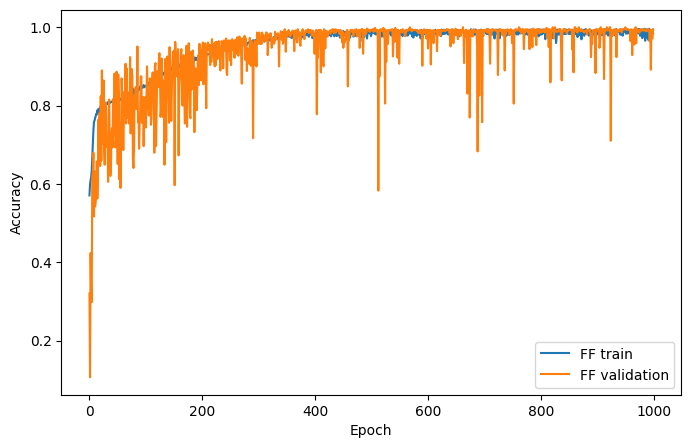

In [47]:
import matplotlib.pyplot as plt

#want to visialise the training history over epochs
plt.figure(figsize=(8, 5)) 
plt.plot(ff_history_df['custom_accuracy'], label='FF train')
plt.plot(ff_history_df['val_custom_accuracy'], label='FF validation')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

Results are slightly puzzling, validation accuracy is very high, yet the test results are not in agreement

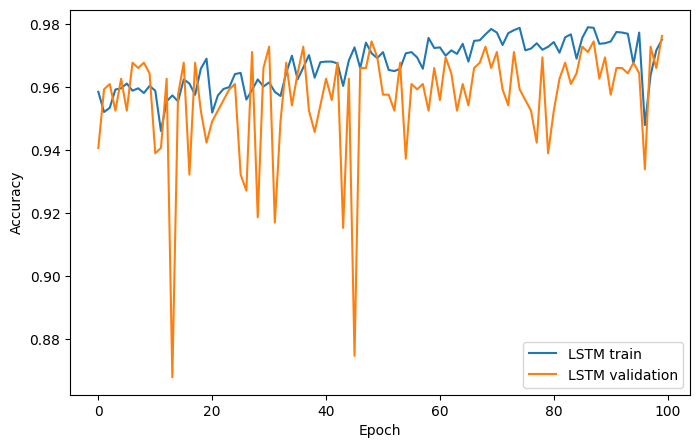

In [37]:
import matplotlib.pyplot as plt

#want to visialise the training history over epochs
plt.figure(figsize=(8, 5)) 
plt.plot(lstm_history_df['custom_accuracy'], label='LSTM train')
plt.plot(lstm_history_df['val_custom_accuracy'], label='LSTM validation')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

37/37 [==============================] - 0s 2ms/step - loss: 1.1761 - custom_accuracy: 0.7179
LSTM Model - Test Loss: 1.1761199235916138, Test Accuracy: 0.717860221862793
37/37 [==============================] - 0s 429us/step
LSTM Model ROC-AUC Score: 0.7514515703351807
Feed-Forward Model ROC-AUC Score: 0.7675524142414821


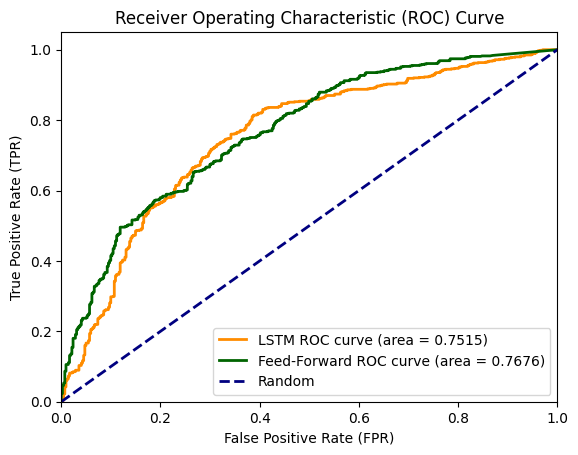

In [38]:
from sklearn.metrics import roc_curve, auc, roc_auc_score

# Assuming 'lstmmodel' and 'ffmodel' are your trained Keras models
# Evaluate the LSTM model on the test set
test_loss, test_accuracy = lstmmodel.evaluate([test_texts, test_other_features], y_test)
print(f"LSTM Model - Test Loss: {test_loss}, Test Accuracy: {test_accuracy}")

# Predict probabilities for the test set
lstm_y_pred_probs = lstmmodel.predict([test_texts, test_other_features]).ravel()
ff_y_pred_probs = ffmodel.predict(X_test).ravel()

# Calculate ROC-AUC for both models
lstm_roc_auc = roc_auc_score(y_test, lstm_y_pred_probs)
ff_roc_auc = roc_auc_score(y_test, ff_y_pred_probs)
print(f"LSTM Model ROC-AUC Score: {lstm_roc_auc}")
print(f"Feed-Forward Model ROC-AUC Score: {ff_roc_auc}")

# Compute ROC curve and ROC area for both models
fpr_lstm, tpr_lstm, _ = roc_curve(y_test, lstm_y_pred_probs)
roc_auc_lstm = auc(fpr_lstm, tpr_lstm)

fpr_ff, tpr_ff, _ = roc_curve(y_test, ff_y_pred_probs)
roc_auc_ff = auc(fpr_ff, tpr_ff)

# Plot ROC curve for LSTM model
plt.figure()
plt.plot(fpr_lstm, tpr_lstm, color='darkorange', lw=2, label=f'LSTM ROC curve (area = {roc_auc_lstm:.4f})')

# Plot ROC curve for Feed-Forward model
plt.plot(fpr_ff, tpr_ff, color='darkgreen', lw=2, label=f'Feed-Forward ROC curve (area = {roc_auc_ff:.4f})')

# Plot random chance line
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', label='Random')

# Add labels and legend
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate (FPR)')
plt.ylabel('True Positive Rate (TPR)')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()

## Model Explainability (FF)
- We use LIME, which trains a linear classifier around a specific training instance from our ffmodel, to derive our how our model weighs different features for that instance.

In [40]:
from lime.lime_tabular import LimeTabularExplainer
lime_train_sample = X_train 
# Set up LIME explainer using the sampled data
explainer = LimeTabularExplainer(
    training_data=lime_train_sample,  # Use the sampled data
    feature_names=feature_names,
    class_names=["Negative", "Positive"],
    discretize_continuous=False,
    sample_around_instance=True
)

# Define the prediction function for LIME
def predict_fn(data):
    # Get predictions for one class
    preds = ffmodel.predict(X_train)
    # Convert predictions to two columns (probabilities for both classes)
    # Assuming preds are the probabilities for class 1
    return np.hstack([1 - preds, preds])

1/1 [==============================] - 0s 12ms/step
Document ID: 300
Document content: ['user', 'ooks', 'green', ',', 'plus', '3', '%', 'got', 'out', 'buying', '35.25', 'today', 'ddd']
Probability (of Positive Sentiment)) = 0.9998817
True class: 1


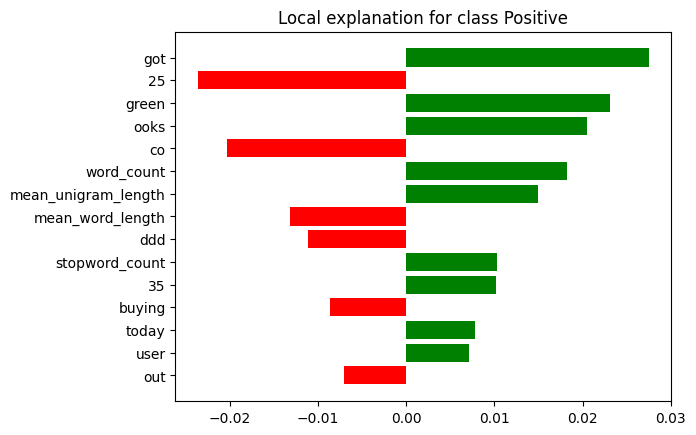

In [51]:
for idx_to_explain in [300]:
    exp = explainer.explain_instance(
        data_row= X_train[idx_to_explain],
        predict_fn=predict_fn,
        num_features=15,   # Limit to top 20 features
        num_samples=5894,
        distance_metric='cosine'
    )
    fig = exp.as_pyplot_figure()  
    predicted_proba = ffmodel.predict(X_train[idx_to_explain].reshape(1, -1))[0][0]
    print('Document ID: %d' % idx_to_explain)
    print('Document content: %s' % train["Text_unigram"][idx_to_explain])
    print('Probability (of Positive Sentiment)) =', predicted_proba)
    print('True class: %s' % y_train[idx_to_explain])

Using training row 300 as an example, we generally see that both token appearances and general text features eg. word_count, char_count are considered. We see that "got" and "green" are very significantly weighed, and positive. 
- We also see significant tokens such as "ooks" that might not make sense to the user. 
- Another token that makes no sense might be "buying" that is weighed negatively. 
- Additionally, the weighing of "25" and "35" that comes from an arbitrary quantitative figure should not hold any significant meaning on its own, yet the model takes it into consideration. 
    
    
Something I do not understand, is the consistent consideration of some tokens over majority of training rows, that do not necessarily appear in the document in question. Here, "co" is one example. "today", and "http" are other frequently appearing examples. Does this mean that the absense of "co" contributes negatively to the document's sentiment score?

## References
- https://github.com/marcotcr/lime